In [13]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
import ydf
from keras.applications import MobileNetV2 # Supposedly good model for small 64x64 images

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from PIL import Image

In [ ]:
image_folder = "PetImages"
subfolders = ["Cat", "Dog"]
bad_images = []

print("Looking for Corrupt images")

for subfolder in subfolders:
    folder_path = os.path.join(image_folder, subfolder)

    if not os.path.exists(folder_path):
        print(f"Directory not found: {folder_path}. Skipping.")
        continue

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        try:
            # Read the raw file data
            raw_image_data = tf.io.read_file(file_path)
            # Attempt to decode it using TensorFlow's engine
            # This is the same operation that fails during training
            tf.io.decode_image(raw_image_data)
            
        except tf.errors.InvalidArgumentError:
            # This is the specific error we are looking for
            print(f"Corrupt file found: {file_path}")
            bad_images.append(file_path)
        
        except Exception as e:
            # Catch any other potential errors
            print(f"An unexpected error occurred for file {file_path}: {e}")
            bad_images.append(file_path)

print(f"Total corrupt images found: {len(bad_images)}")
print(bad_images)


print("\nDeleting corrupt files")
for fpath in bad_images:
    try:
        os.remove(fpath)
        print(f"Deleted: {fpath}")
    except OSError as e:
        print(f"Error deleting {fpath}: {e}")
print("Deletion complete.")

Starting TensorFlow-based image verification...
Corrupt file found (TF): PetImages\Cat\10404.jpg
Corrupt file found (TF): PetImages\Cat\4351.jpg
Corrupt file found (TF): PetImages\Cat\Thumbs.db
Corrupt file found (TF): PetImages\Dog\11233.jpg
Corrupt file found (TF): PetImages\Dog\11912.jpg
Corrupt file found (TF): PetImages\Dog\2317.jpg
Corrupt file found (TF): PetImages\Dog\2494.jpg
Corrupt file found (TF): PetImages\Dog\9500.jpg
Corrupt file found (TF): PetImages\Dog\Thumbs.db

---------------------------------
Total corrupted or problematic images found: 9
['PetImages\\Cat\\10404.jpg', 'PetImages\\Cat\\4351.jpg', 'PetImages\\Cat\\Thumbs.db', 'PetImages\\Dog\\11233.jpg', 'PetImages\\Dog\\11912.jpg', 'PetImages\\Dog\\2317.jpg', 'PetImages\\Dog\\2494.jpg', 'PetImages\\Dog\\9500.jpg', 'PetImages\\Dog\\Thumbs.db']

Deleting corrupted files...
Deleted: PetImages\Cat\10404.jpg
Deleted: PetImages\Cat\4351.jpg
Deleted: PetImages\Cat\Thumbs.db
Deleted: PetImages\Dog\11233.jpg
Deleted: PetIma

In [22]:
image_folder = "PetImages/"
img_size = (64, 64)
batch_size = 32

# Create a training dataset directly from the directory
# automatically infers class labels from the folder names
train_dataset = tf.keras.utils.image_dataset_from_directory(
    image_folder,
    validation_split=0.2,  # Use 20% of the images for validation
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    image_folder,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_dataset.class_names
print("Class names found:", class_names)

Found 24991 files belonging to 2 classes.
Using 19993 files for training.
Found 24991 files belonging to 2 classes.
Using 4998 files for validation.
Class names found: ['Cat', 'Dog']


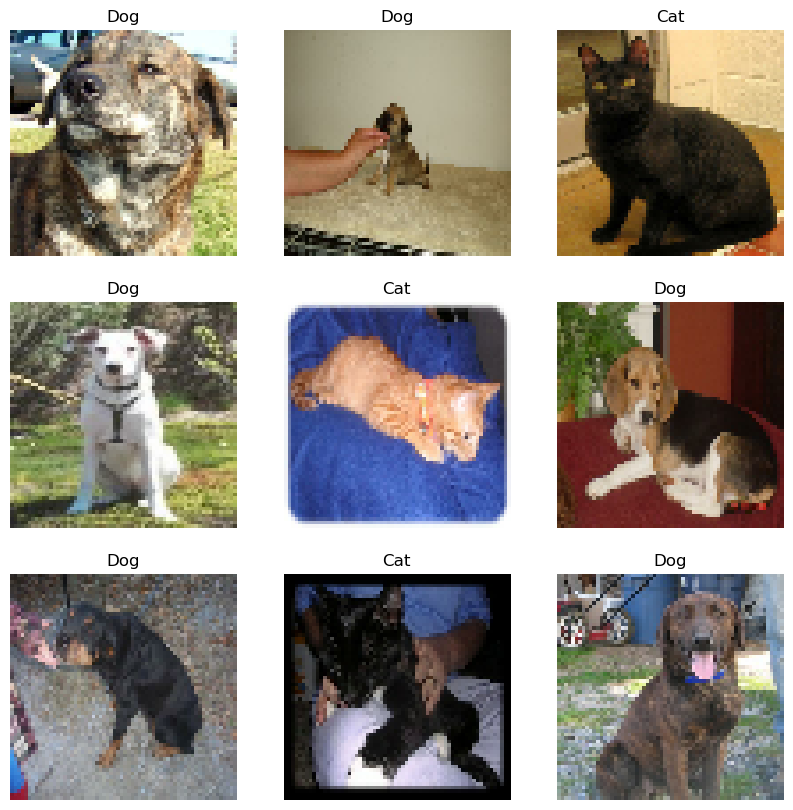

In [23]:
plt.figure(figsize=(10, 10))

# Take one batch from the dataset
# A batch contains a tensor of images and a tensor of their corresponding labels
for images, labels in train_dataset.take(1):
  # `images` is a batch of images (e.g., 32 images of shape 64x64x3)
  # `labels` is a batch of labels (e.g., 32 integers from 0 to n_classes-1)
  
  # Loop through the first 9 images in the batch
  for i in range(9):
    # Create a subplot for each image
    ax = plt.subplot(3, 3, i + 1)
    
    # Display the image
    # Note: Keras reads images as tf.Tensor, matplotlib expects NumPy arrays.
    # If you haven't normalized yet use uint8, use float32 for normalized
    plt.imshow(images[i].numpy().astype("uint8"))
    
    # Get the corresponding label name from the class_names list
    label_name = class_names[labels[i]]
    plt.title(label_name)
    
    # Hide the axes
    plt.axis("off")

# Display the plot
plt.show()

In [24]:
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for batch_images, batch_labels in dataset:
        images.append(batch_images.numpy())
        labels.append(batch_labels.numpy())
    images = np.concatenate(images)
    labels = np.concatenate(labels)
    return images, labels

# extract image data from dataset objects to 4d numpy arrays
X_train, y_train = dataset_to_numpy(train_dataset)
X_val, y_val = dataset_to_numpy(validation_dataset)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (19993, 64, 64, 3)
Validation set shape: (4998, 64, 64, 3)


In [25]:
# normalize image data to be between 0 and 1
X_train = X_train / 255.0
X_val = X_val / 255.0

# Flatten images to 2d array for RF model
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

print("Flattened X_train shape:", X_train.shape)
print("Flattened X_val shape:", X_val.shape)

Flattened X_train shape: (19993, 12288)
Flattened X_val shape: (4998, 12288)


In [ ]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest...")
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=class_names))
print("Accuracy:", accuracy_score(y_val, y_pred))

Training Random Forest...


KeyboardInterrupt: 

In [6]:
feature_extractor = MobileNetV2(
    weights='imagenet',
    include_top=False,        # Exclude the final classification layer
    pooling='avg',            # Average the features into a single vector per image
    input_shape=(*img_size, 3)
)

# --- 3. Define a Function to Extract Features from a Dataset ---
def extract_features(dataset, extractor_model):
    """Iterates through a tf.data.Dataset, extracts features, and returns them as NumPy arrays."""
    all_features = []
    all_labels = []

    print("Extracting features...")
    # Iterate through each batch of images and labels in the dataset
    for images, labels in dataset:
        # Use the specific preprocessing function for MobileNetV2
        preprocessed_images = tf.keras.applications.mobilenet_v2.preprocess_input(images)
        
        # Get feature vectors from the extractor model
        features = extractor_model.predict(preprocessed_images, verbose=0)
        
        # Store the results from the batch
        all_features.append(features)
        all_labels.append(labels.numpy())

    # Concatenate all batches into single NumPy arrays
    return np.concatenate(all_features), np.concatenate(all_labels)

# --- 4. Process Both Datasets ---
train_features, train_labels = extract_features(train_dataset, feature_extractor)
val_features, val_labels = extract_features(validation_dataset, feature_extractor)

print(f"\nShape of training features: {train_features.shape}")
print(f"Shape of validation features: {val_features.shape}")

# --- 5. Convert to Pandas DataFrames for YDF ---
# Create column names for the features
feature_columns = [f'feature_{i}' for i in range(train_features.shape[1])]

# Create the training DataFrame
train_df = pd.DataFrame(train_features, columns=feature_columns)
train_df['label'] = train_labels

# Create the validation DataFrame (which we'll use for testing)
test_df = pd.DataFrame(val_features, columns=feature_columns)
test_df['label'] = val_labels

print("\nTraining DataFrame head:")
print(train_df.head())

# --- 6. Train and Evaluate the YDF Random Forest Model ---
print("\nTraining YDF Random Forest model...")

# Define the model. YDF will automatically detect the classification task.
rf_model = ydf.RandomForestLearner(label="label").train(train_df)

# Evaluate the model's performance on the validation data
print("\nEvaluating model performance...")
evaluation = rf_model.evaluate(test_df)

print("\nEvaluation Report:")
print(evaluation)

accuracy = evaluation.accuracy
print(f"\nModel Accuracy on Validation Set: {accuracy * 100:.2f}%")

C:\Users\Mail Moolbaes\AppData\Local\Temp\ipykernel_13604\358037125.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  feature_extractor = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Extracting features...
Extracting features...

Shape of training features: (19993, 1280)
Shape of validation features: (4998, 1280)

Training DataFrame head:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   1.742656        0.0   0.040768        0.0   5.307450        0.0   
1   0.000000        0.0   0.000000        0.0   4.261316        0.0   
2   0.000000        0.0   0.000000        0.0   0.000000        0.0   
3   2.108096        0.0   0.105618        0.0   0.000000        0.0   
4   0.000000        0.0   0.000000        0.0   0.000000        0.0   

   feature_6  feature_7  feature_8  feature_9  ...  feature_1271  \
0   3.168020   0.000000   0.000000   6.000000  ...      0.000000   
1   5.842039   0.908353   0.000000   0.595312  ...      0.000000   
2   0.000000   0.000000   0.000000   0.000000  ...      0.487298   
3   3.023441   0.000000   0.000000   0.000000  ...      0.000000   
4   0.000000   0.023548   